## To eliminate regions from flood maps with very low discharge, make a mask based on CTRL mean annual discharge 
* Regions with discharge < 0.01 mm/day should be masked out (to match H13) 
* Need gridcell area * discharge 

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
import time 
import xarray as xr
import pickle 
import os

from netCDF4 import Dataset

In [13]:
#Read in CaMa gridcell areas [m^2]
matData = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/CaMa_gridAreas.mat')
area    = matData['area']

#Read in average outflow in CTRL [km^3/day]
matData   = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/control_outflw.mat')
#avgFlow = matData['avgYearly_full']
avgFlow = matData['avgVar_full']

In [61]:
# np.shape(np.nanmean(avgFlow,axis=2))
# print(np.nanmean(np.nanmean(np.nanmean(avgFlow,axis=2))))
# testArr = np.nanmean(avgFlow,axis=2)
# testArr = testArr*(1e9)*1000/area
# print(np.nanmean(np.nanmean(testArr)))



/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


0.017671728579906884
30.865373837389924


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#Print status updates 
print('km^3/day: ',avgFlow[100:105,100])

# Convert avgFlow to m^3/day
avgFlow = avgFlow*(1e9)  
print('m^3/day: ',avgFlow[100:105,100])

#Convert to m/day (by dividing by area)
avgFlow = avgFlow/area 
print('m/day: ',avgFlow[100:105,100])

#Convert from m/day to mm/day 
avgFlow = avgFlow*1000
print('mm/day: ',avgFlow[100:105,100])

print(np.nanmean(np.nanmean(avgFlow)))

km^3/day:  [5.95581797e-05 8.74532282e-01 8.74262596e-01 2.24508745e-02
 3.96474332e-04]
m^3/day:  [5.95581797e+04 8.74532282e+08 8.74262596e+08 2.24508745e+07
 3.96474332e+05]
m/day:  [1.81518029e-04 2.66534970e+00 2.66452777e+00 6.84244971e-02
 1.20835190e-03]
mm/day:  [1.81518029e-01 2.66534970e+03 2.66452777e+03 6.84244971e+01
 1.20835190e+00]
30.865373837389914


In [15]:
#Make mask of really dry regions to eliminate 
dryMask = np.ones(np.shape(area))

#Set mask to zero when average flow is less than 0.01 mm/day 
dryMask[np.where(avgFlow<0.01)]=np.nan


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [18]:
i= np.where(np.isnan(dryMask))
np.shape(i)

(2, 28446)

In [55]:
i = np.where( (avgFlow>-0.01)& (avgFlow<0.01))
np.shape(i)

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(2, 189)

In [19]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

### Create a list of RGB tuples
colorsList = [(27,30,72), (62,86,170), (81,144,208), (104,200,220),(166,227,221), 
           (221,238,247), (248,247,100),(250,203,0),(249,81,1), (246,80,149),(242,30,15)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap = make_cmap(colorsList, bit=True)

In [20]:
#Load in original return periods 
fullData = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/pyTfull.mat')
Tfull    = fullData['Tfull']

CaMaFile = Dataset('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/fldare1161.nc')
# print(CaMaFile.dimensions.keys())|

lat =  CaMaFile.variables['lat'][:] 
lon = CaMaFile.variables['lon'][:] 

In [21]:
# Define array of colors for maps

#If figures are to use significance test when plotting, turn sigPlot to 1:
sigPlot = 0
if sigPlot==1:
    Tfull_col = Tfull_sig
else:
    Tfull_col = Tfull

colorsFull = np.full([len(lon),len(lat)],np.nan)
colorsFull[np.where((Tfull_col>=2)  & (Tfull_col<=5))]     = 1
colorsFull[np.where((Tfull_col>5)   & (Tfull_col<=25))]    = 2
colorsFull[np.where((Tfull_col>25)  & (Tfull_col<=50))]    = 3
colorsFull[np.where((Tfull_col>50)  & (Tfull_col<=75))]    = 4
colorsFull[np.where((Tfull_col>75)  & (Tfull_col<=95))]    = 5
colorsFull[np.where((Tfull_col>95)  & (Tfull_col<=105))]   = 6
colorsFull[np.where((Tfull_col>105) & (Tfull_col<=125))]   = 7
colorsFull[np.where((Tfull_col>125) & (Tfull_col<=250))]   = 8
colorsFull[np.where((Tfull_col>250) & (Tfull_col<=500))]   = 9
colorsFull[np.where((Tfull_col>500) & (Tfull_col<=1000))]  = 10
colorsFull[np.where(Tfull_col>1000)]                       = 11



In [22]:
np.shape(colorsFull)

(1440, 720)

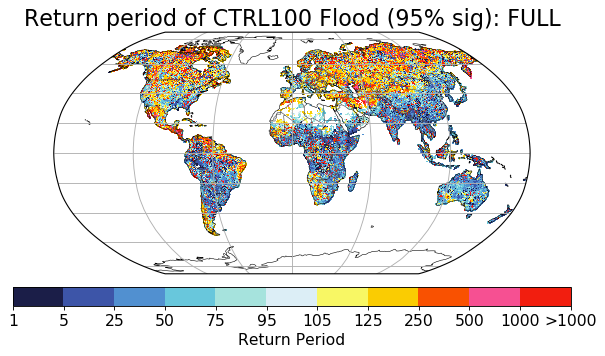

In [24]:
## PLOT TFULL RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')

my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsFullT = np.transpose(colorsFull*dryMask)
contour_plot = ax.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Return period of CTRL100 Flood (95% sig): FULL')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')